# N-body simulations

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='0.5' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

2025-01-20 17:34:17.807893: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Compensation

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint
from jaxpm.growth import growth_factor
kpks = []
a_obs = 1.

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs, model.snapshots)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh

for mesh_length in [64, 128, 256]:
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            a_lpt = 0.1 if pm else a_obs
            config = {
                        'mesh_shape':3 * (mesh_length,),
                        'box_shape':3 * (640.,),
                        'a_lpt':a_lpt,
                        'a_obs':a_obs,
                        'lpt_order':lpt_order,
                        'precond':0,
                        'obs':'mesh'
                        }
            model = FieldLevelModel(**default_config | config)

            cosmology = Planck18()
            pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
            linmesh = jr.normal(jr.key(0), model.mesh_shape)
            linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
            init = {'init_mesh':linmesh}
            params = cosmology, init

            mesh = evolve(model, params)
            kpk = model.spectrum(mesh, comp=True)
            kpks.append(kpk)

            D1 = growth_factor(cosmology, jnp.atleast_1d(a_obs))
            kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
            kpks.append(kpklin)

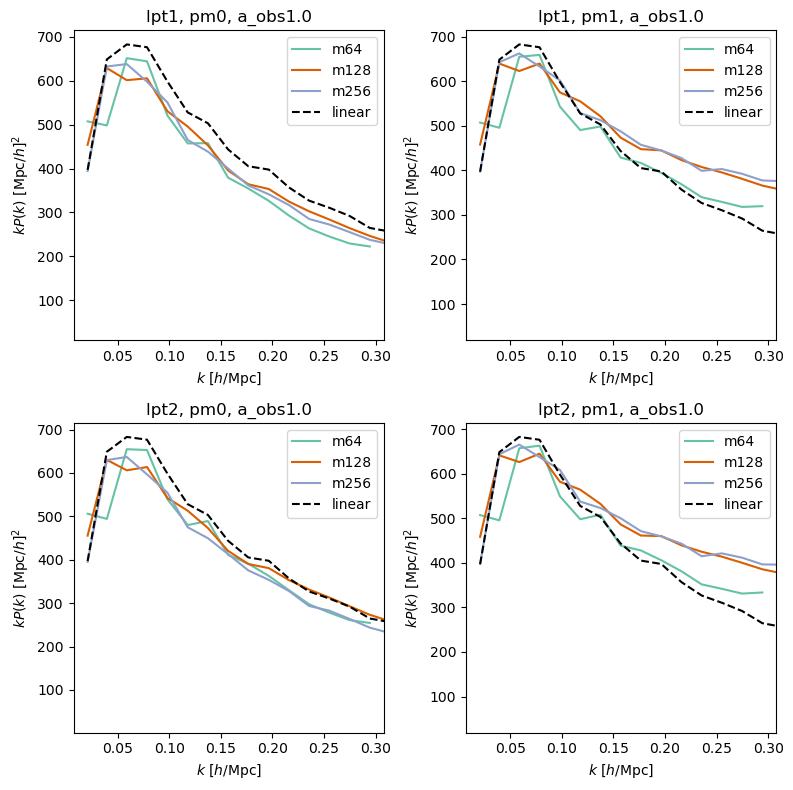

In [11]:
from montecosmo.plot import plot_pk, plot_trans, theme
theme()

plt.figure(figsize=(8, 8))
i_count = 0
for mesh_length in [64, 128, 256]:
    i_plt = 0
    for lpt_order in [1, 2]:
        for pm in [0,1]:
            kpk = kpks[i_count]
            kpklin = kpks[i_count+1]

            plt.subplot(2, 2, i_plt+1)
            plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

            # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')
            
            plot_pk(*kpk, label=f'm{mesh_length}')
            if i_count>15:
                plot_pk(*kpklin, 'k--', label='linear')
            
            plt.xlim(*plt.xlim())
        
            plt.legend()
            i_count += 2
            i_plt += 1
plt.tight_layout()

## Gaussianity

In [10]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, lpt, nbody, cic_paint, rfftk
from jaxpm.growth import growth_factor

def evolve(model, params:tuple):
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape).reshape(3,-1).T

    # LPT displacement at a_lpt
    # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
    cosmology._workspace = {}  # HACK: temporary fix
    dq, p, f = lpt(cosmology, **init, positions=q, a=model.a_lpt, order=model.lpt_order)
    particles = jnp.stack([q + dq, p])

    # PM displacement from a_lpt to a_obs
    particles = nbody(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs, model.snapshots)
    particles = particles[-1]

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh


config = {
            'mesh_shape':3 * (256,),
            'box_shape':3 * (10000.,),
            'a_lpt':0.1,
            'a_obs':1.,
            'lpt_order':2,
            'precond':0,
            'obs':'mesh'
            }
model = FieldLevelModel(**default_config | config)

cosmology = Planck18()
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
seed = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(seed) * pmeshk**.5
params = cosmology, {'init_mesh':linmesh}

mesh = evolve(model, params) - 1
k, pk = model.spectrum(mesh, comp=True)

pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, jnp.log(pk), left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
kvec = rfftk(model.mesh_shape)
k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, model.mesh_shape, model.box_shape))**0.5
pmeshk = pk_fn(k_box) * (model.mesh_shape / model.box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units
gaussmesh = jnp.fft.irfftn(jnp.fft.rfftn(seed) * pmeshk**.5)

D1 = growth_factor(cosmology, jnp.atleast_1d(model.a_obs))
linmesh = jnp.fft.irfftn(linmesh * D1)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

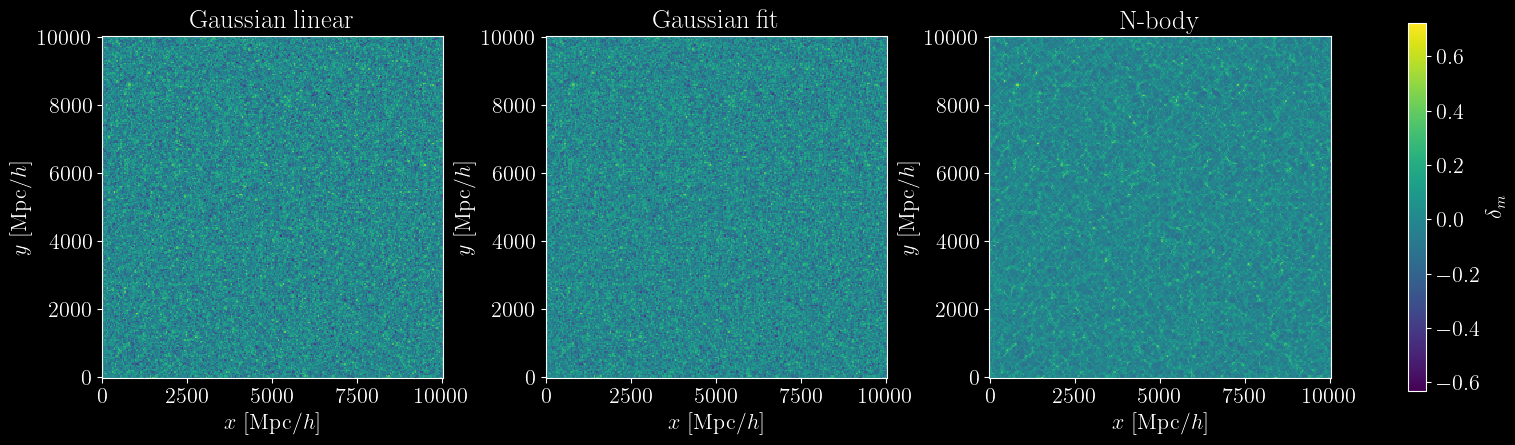

In [11]:
from montecosmo.plot import plot_mesh, theme
dark = True
theme(dark=dark, usetex=True, font_size=16)


mesh_toplot = jnp.stack([linmesh, gaussmesh, mesh])
vlim = 1e-2*5
vlim = jnp.array([vlim/2, 1-vlim/2])
vlim = jnp.quantile(mesh_toplot, vlim)
sli = 1/20

titles = ['Gaussian linear', 'Gaussian fit', 'N-body']

plt.figure(figsize=(17, 5))
for i_plt, m in enumerate(mesh_toplot):
    plt.subplot(1, 3, i_plt+1)
    plt.title(titles[i_plt])
    plot_mesh(m, model.box_shape, sli=sli, vlim=vlim)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.colorbar(ax=plt.gcf().axes).set_label("$\\delta_m$")
fina = f'gaussinity_b{model.box_shape[0]:.0f}'
if dark: fina += '_dk'
plt.savefig(fina+'.png', dpi=200)

## BullFrog

In [2]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.bricks import lin_power_mesh, Planck18, rsd_bf, rsd_fpm
from montecosmo.nbody import lpt, nbody_tsit5, nbody_bf
from jaxpm.painting import cic_paint
from jaxpm.growth import growth_factor, growth_rate
import jax_cosmo as jc

a_obs = 1.
a_lpt = 0.01 
solvers = ['bullfrog', 'tsit5']
mesh_length, box_length = 64, 640.
lpt_order = 1
grad_fd = False
rsd = True

config = {
            'mesh_shape':3 * (mesh_length,),
            'box_shape':3 * (box_length,),
            'a_lpt':a_lpt,
            'a_obs':a_obs,
            'lpt_order':lpt_order,
            'precond':0,
            'obs':'mesh'
            }

def evolve(model, params:tuple, solver='bullfrog', grad_fd=False, lap_fd=False, rsd=False, n_steps=50): # grad_fd=False, lap_fd=False, no deconv, for pmwd
    cosmology, init = params

    # Create regular grid of particles
    q = jnp.indices(model.mesh_shape, dtype=jnp.float32).reshape(3,-1).T

    if solver == 'bullfrog':
        cosmology._workspace = {}  # HACK: temporary fix
        particles = nbody_bf(cosmology, **init, pos=q, a=model.a_obs, n_steps=n_steps, grad_fd=grad_fd, lap_fd=lap_fd)

        if rsd:
            # RSD displacement at a_obs
            dq = rsd_bf(cosmology, model.a_obs, particles[1])
            particles = particles.at[0].add(dq)
            vel = particles[1] * growth_factor(cosmology, model.a_obs) * growth_rate(cosmology, model.a_obs)
        else: 
            vel = None

    elif solver == 'tsit5':
        # LPT displacement at a_lpt
        # NOTE: lpt assumes given mesh follows linear pk at a=1, and then correct by growth factor for target a_lpt
        cosmology._workspace = {}  # HACK: temporary fix
        dq, p = lpt(cosmology, **init, pos=q, a=model.a_lpt, order=model.lpt_order, grad_fd=grad_fd, lap_fd=lap_fd)
        particles = jnp.stack([q + dq, p])

        # PM displacement from a_lpt to a_obs
        particles = nbody_tsit5(cosmology, model.mesh_shape, particles, model.a_lpt, model.a_obs, 
                                model.snapshots, tol=1e-4, grad_fd=grad_fd, lap_fd=lap_fd)
        particles = particles[-1]

        if rsd:
            # RSD displacement at a_obs
            dq = rsd_fpm(cosmology, model.a_obs, particles[1])
            particles = particles.at[0].add(dq)
            vel = particles[1] / (jc.background.Esqr(cosmology, model.a_obs)**.5 * model.a_obs**2)
        else: 
            vel = None

    # CIC paint weighted by Lagrangian bias expansion weights
    biased_mesh = cic_paint(jnp.zeros(model.mesh_shape), particles[0])
    return biased_mesh, vel

### Growth functions

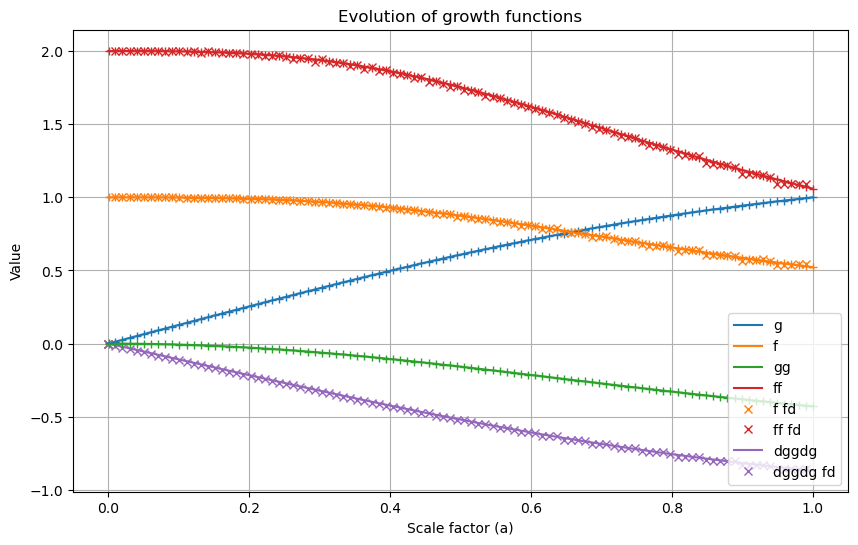

In [ ]:
from jaxpm.growth import growth_factor as g, growth_rate as f, growth_factor_second as gg, growth_rate_second as ff
from montecosmo.bricks import Planck18
cosmo = Planck18()
a = jnp.linspace(0, 1, 100)
gs = g(cosmo, a)
f_values = f(cosmo, a)
gg_values = gg(cosmo, a)*(-3/7)
ff_values = ff(cosmo, a)
from montecosmo.nbody import g2a, g2gg, g2f, g2ff
aa = g2a(cosmo, gs)
fs = g2f(cosmo, gs)
ggs = g2gg(cosmo, gs)*(-3/7)
ffs = g2ff(cosmo, gs)

dg = jnp.diff(jnp.log(gs))/jnp.diff(jnp.log(a))
dgg = jnp.diff(jnp.log(gg_values*-1))/jnp.diff(jnp.log(a))

def dggdg(cosmo, g):
    gg, f, ff = g2gg(cosmo, g)*(-3/7), g2f(cosmo, g), g2ff(cosmo, g)
    return jnp.where(g==0., 0., gg * ff / (g * f))
dggdgs_fd = jnp.diff(gg_values)/jnp.diff(gs)
dggdgs = dggdg(cosmo, gs)

plt.figure(figsize=(10, 6))
plt.plot(a, gs, 'C0', label='g')
plt.plot(a, f_values, 'C1', label='f')
plt.plot(a, gg_values, 'C2', label='gg')
plt.plot(a, ff_values, 'C3', label='ff')

plt.plot(a[:-1], dg, 'C1x', label='f fd')
plt.plot(a[:-1], dgg, 'C3x', label='ff fd')

plt.plot(a, dggdgs, 'C4', label='dggdg')
plt.plot(a[:-1], dggdgs_fd, 'C4x', label='dggdg fd')

plt.plot(aa, gs, 'C0+')
plt.plot(aa, fs, 'C1+')
plt.plot(aa, ggs, 'C2+')
plt.plot(aa, ffs, 'C3+')
plt.xlabel('Scale factor (a)')
plt.ylabel('Value')
plt.legend()
plt.title('Evolution of growth functions')
plt.grid(True)
plt.show()


### PMWD comparison

In [5]:
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody as nbody_pmwd, lpt as lpt_pmwd
import jax
from jaxpm.growth import growth_factor
import jax_cosmo as jc

ptcl_spacing = box_length / mesh_length # Mpc/h
ptcl_grid_shape = (mesh_length,)*3
mesh_shape = np.array((mesh_length,)*3)
box_shape = np.array((box_length,)*3)
zeros_mesh = jnp.zeros(mesh_shape)

def run_pmwd(a_lpt=.1, a_obs=1., lpt_order=1, rsd=False):
    jax.config.update("jax_enable_x64", True)
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=lpt_order,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1/64)
    # cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    # XXX: sigma8 redshift dependant???
    cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    cosmo = boltzmann(cosmo, conf)

    cosmology = Planck18()
    pmeshk = lin_power_mesh(cosmology, mesh_shape, box_shape)
    init_modes = jr.normal(jr.key(0), mesh_shape)
    init_modes = jnp.fft.rfftn(init_modes) * pmeshk**.5

    init_modes *= growth_factor(cosmology, jnp.atleast_1d(a_lpt)) / growth(a_lpt, cosmo, conf, order=1) * conf.ptcl_cell_vol
    ptcl, obsvbl = lpt_pmwd(init_modes, cosmo, conf)
    # return ptcl.disp/ptcl_spacing

    # modes = white_noise(0, conf)
    # field = jr.normal(jr.key(0), mesh_shape)
    # modes = jnp.fft.rfftn(field, norm="ortho")
    # modes = linear_modes(modes, cosmo, conf)        
    # ptcl, obsvbl = lpt_pmwd(modes, cosmo, conf)
    
    ptcl, obsvbl = nbody_pmwd(ptcl, obsvbl, cosmo, conf)
    jax.config.update("jax_enable_x64", False)
    if rsd:
        dx_rsd = ptcl.vel / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        pos = ptcl.pos() + dx_rsd * jnp.array([0,0,1])
    else:
        pos = ptcl.pos()
    
    # return scatter(ptcl, conf)
    return cic_paint(zeros_mesh, pos/ptcl_spacing)

In [6]:
import time
solvers = ['bullfrog', 'tsit5', 'pmwd']
model = FieldLevelModel(**default_config | config)
print(model)

cosmology = Planck18()
pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
linmesh = jr.normal(jr.key(0), model.mesh_shape)
linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
init = {'init_mesh':linmesh}
params = cosmology, init

D1 = growth_factor(cosmology, a_obs)
linmesh = jnp.fft.irfftn(linmesh * D1)
kpklin = model.spectrum(linmesh)

jax.config.update("jax_enable_x64", False)
start_time = time.time()
mesh_pmwd = run_pmwd(a_lpt, a_obs, lpt_order, rsd=rsd)
print(f'pmwd time: {time.time()-start_time:.2f}s')

start_time = time.time()
mesh_ts, dx_ts = evolve(model, params, solver='tsit5', grad_fd=grad_fd, lap_fd=False, rsd=rsd)
print(f'tsit5 time: {time.time()-start_time:.2f}s')

start_time = time.time()
mesh_bf, dx_bf = evolve(model, params, solver='bullfrog', grad_fd=grad_fd, lap_fd=False, rsd=rsd)
print(f'bullfrog time: {time.time()-start_time:.2f}s')
jax.config.update("jax_enable_x64", False)

kptcs = []
kptc = model.pktranscoh(linmesh, mesh_bf, comp=(False, True))
kptcs.append(kptc)
kptc = model.pktranscoh(linmesh, mesh_ts, comp=(False, True))
kptcs.append(kptc)
kptc = model.pktranscoh(linmesh, mesh_pmwd, comp=(False, True))
kptcs.append(kptc)

# kptcs2 = []
# kptc = model.pktranscoh(mesh_bf, mesh_bf, comp=True)
# kptcs2.append(kptc)
# kptc = model.pktranscoh(mesh_bf, mesh_ts, comp=True)
# kptcs2.append(kptc)
# kptc = model.pktranscoh(mesh_bf, mesh_pmwd, comp=True)
# kptcs2.append(kptc)

# CONFIG
{'a_lpt': 0.01,
 'a_obs': 1.0,
 'box_shape': array([640., 640., 640.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
              

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

pmwd time: 2.32s
n_solvsteps: 6
tsit5 time: 3.18s
bullfrog time: 1.03s


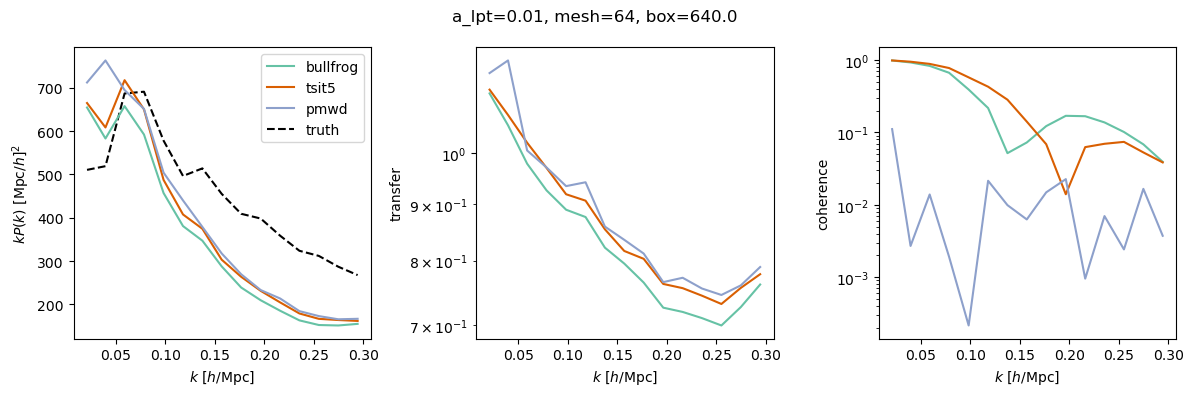

In [16]:
from montecosmo.plot import plot_pktranscoh, plot_pk, theme, SetDark2
theme()
log = False
vslin = True
kp = kptcs if vslin else kptcs2
sfx = '' if vslin else 'vs_bf'

plt.figure(figsize=(12,4))
for i_plt, kptc in enumerate(kp):
    plot_pktranscoh(*kptc, log=log, label=f"{solvers[i_plt]}")
plt.subplot(1,3,1)
plot_pk(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()
plt.suptitle(f"{a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_gradfd{grad_fd:d}_rsd{rsd:d}'+sfx+'.png', dpi=200)

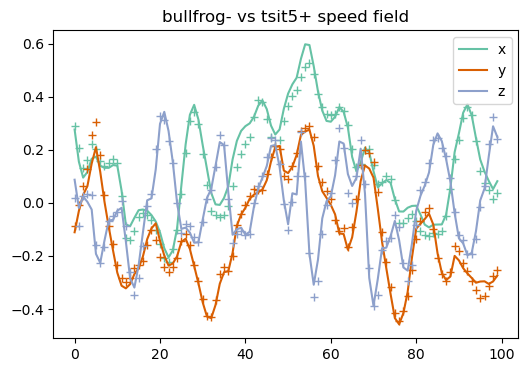

In [31]:
i_plt = 100
plt.figure(figsize=(6, 4))
for i_c, coord in enumerate(['x', 'y', 'z']):
    plt.plot(dx_bf[:i_plt, i_c], c=SetDark2(i_c), label=coord)
    plt.plot(dx_ts[:i_plt, i_c], '+', c=SetDark2(i_c))
plt.title(f"{solvers[0]}- vs {solvers[1]}+ speed field")
plt.legend()
plt.show()

### Temporal convergence

In [6]:
import time
kptcs = []
a_obs = 1.
solvers = ['bullfrog']
mesh_length = 256
box_length = 640.
nstps = [5, 10, 20, 50]

for solver in solvers:
    for nstp in nstps:
        config = {
                    'mesh_shape':3 * (mesh_length,),
                    'box_shape':3 * (box_length,),
                    'a_lpt':-1,
                    'a_obs':a_obs,
                    'lpt_order':-1,
                    'precond':0,
                    'obs':'mesh'
                    }
        model = FieldLevelModel(**default_config | config)

        cosmology = Planck18()
        pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
        linmesh = jr.normal(jr.key(0), model.mesh_shape)
        linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
        init = {'init_mesh':linmesh}
        params = cosmology, init

        start_time = time.time()
        mesh, moment = evolve(model, params, solver=solver, grad_fd=False, lap_fd=False, n_steps=nstp)
        print(f'{solver} time: {time.time()-start_time:.2f}s')
        
        D1 = growth_factor(cosmology, a_obs)
        linmesh = jnp.fft.irfftn(linmesh * D1)
        kpklin = model.spectrum(linmesh)

        kptc = model.pktranscoh(linmesh, mesh, comp=(False, True))
        kptcs.append(kptc)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


bullfrog time: 1.21s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


bullfrog time: 1.40s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


bullfrog time: 1.62s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


bullfrog time: 2.26s


IndexError: list index out of range

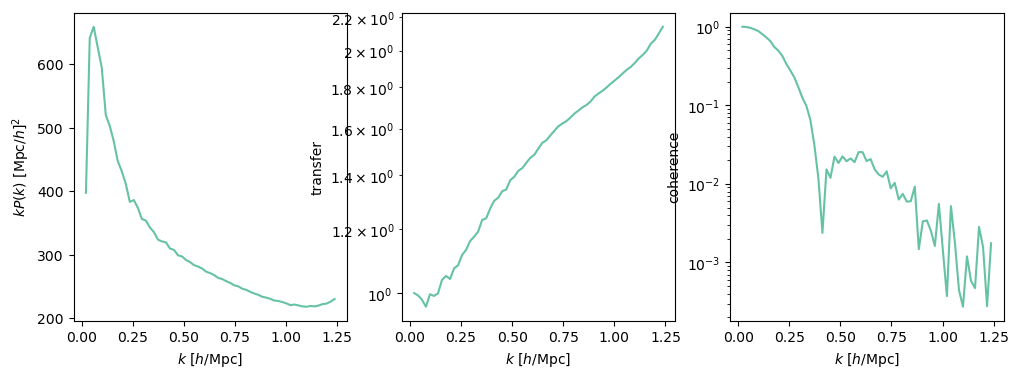

In [8]:
from montecosmo.plot import plot_pktranscoh, plot_pk, theme, SetDark2
theme()
log = False

plt.figure(figsize=(12,4))
for i_plt, kptc in enumerate(kptcs):
    plot_pktranscoh(*kptc, log=log, label=f"{solvers[i_plt]}")
plt.subplot(1,3,1)
plot_pk(*kpklin, 'k--', log=log, label=f"lin", zorder=-1)
plt.legend()
plt.suptitle(f"{a_lpt=}, mesh={mesh_length}, box={box_length}")
plt.tight_layout()
# plt.savefig(f'pmsolv_al{a_lpt}_m{mesh_length}_gradfd{grad_fd:d}_rsd{rsd:d}.png', dpi=200)

### Spatial convergence

In [92]:
import time

kpks = []
a_obs = 1.
solvers = ['bullfrog', 'tsit5']
lengths = [64, 128, 256]
lpt_orders = [2]
pms = [1]

for solver in solvers:
    for mesh_length in lengths:
        for lpt_order in lpt_orders:
            for pm in pms:
                a_lpt = 0.001 if pm else a_obs
                config = {
                            'mesh_shape':3 * (mesh_length,),
                            'box_shape':3 * (640.,),
                            'a_lpt':a_lpt,
                            'a_obs':a_obs,
                            'lpt_order':lpt_order,
                            'precond':0,
                            'obs':'mesh'
                            }
                model = FieldLevelModel(**default_config | config)

                cosmology = Planck18()
                pmeshk = lin_power_mesh(cosmology, model.mesh_shape, model.box_shape)
                linmesh = jr.normal(jr.key(0), model.mesh_shape)
                linmesh = jnp.fft.rfftn(linmesh) * pmeshk**.5
                init = {'init_mesh':linmesh}
                params = cosmology, init

                start_time = time.time()
                mesh = evolve(model, params, solver=solver, grad_fd=False, lap_fd=False).block_until_ready()
                print(f'{solver} time: {time.time()-start_time:.2f}s')
                kpk = model.spectrum(mesh, comp=True)
                kpks.append(kpk)

                D1 = growth_factor(cosmology, a_obs)
                kpklin = model.spectrum(jnp.fft.irfftn(linmesh * D1))
                kpks.append(kpklin)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 0.76s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 0.79s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


rsd
bullfrog time: 1.17s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 6
tsit5 time: 2.16s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 7
tsit5 time: 1.26s


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 12
tsit5 time: 3.09s


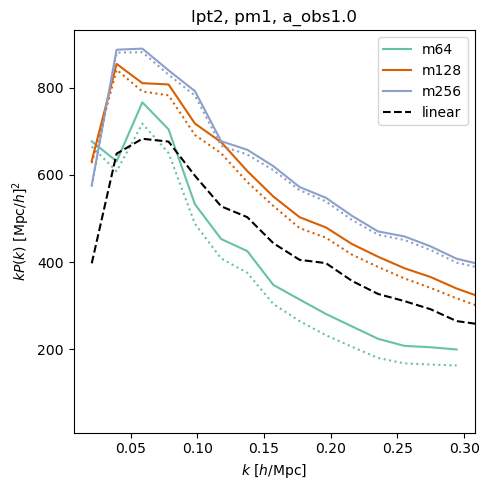

In [93]:
from montecosmo.plot import plot_pk, plot_trans, theme, SetDark2
theme()

plt.figure(figsize=(5, 5))
i_count = 0
for i_s, solver in enumerate(solvers):
    for i_c, mesh_length in enumerate(lengths):
        i_plt = 0
        for lpt_order in lpt_orders:
            for pm in pms:
                kpk = kpks[i_count]
                kpklin = kpks[i_count+1]

                plt.subplot(len(lpt_orders), len(pms), i_plt+1)
                plt.title(f'lpt{lpt_order}, pm{pm}, a_obs{a_obs}')

                style = '-' if solver == 'bullfrog' else ':'
                label = f'm{mesh_length}' if solver == 'bullfrog' else None

                # plot_trans(kpk[0], (kpk[1]/kpklin[1])**.5, label=f'm{mesh_length}')

                plot_pk(*kpk, style, c=SetDark2(i_c), label=label)
                if i_c==len(lengths)-1 and i_s==len(solvers)-1:
                    plot_pk(*kpklin, 'k--', label='linear')
                
                plt.xlim(*plt.xlim())
            
                plt.legend()
                i_count += 2
                i_plt += 1
plt.tight_layout()
# plt.savefig(f'pmsolvers_resol_nodeconv_gradfd1.png', dpi=200)